# Home Credit Default Risk 2018

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import gc
import time
import warnings
from tqdm import tqdm
warnings.simplefilter(action = 'ignore', category = FutureWarning)
try:
    import cPickle as pickle
except:
    import pickle
import os

In [2]:
RANDOM_STATE = 142
np.random.seed(RANDOM_STATE)

In [3]:
file_path = '../input/'
source_path = '../stack_it/stack_source/'

### Service functions

In [4]:
def convert_col_to_proper_int(df_col):
    col_type = df_col.dtype
#     print('convert_col_to_proper_int column: ', df_col.name, 'type: ', col_type, 'c_min: ', c_min)
    if ((str(col_type)[:3] == 'int') | (str(col_type)[:4] == 'uint')): # | (str(col_type)[:5] == 'float')
        c_min = df_col.min()
        c_max = df_col.max()
        if c_min < 0:
#             print('c_min: ', c_min, 'less 0')
            if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                df_col = df_col.astype(np.int8)
            elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                df_col = df_col.astype(np.int16)
            elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                df_col = df_col.astype(np.int32)
            elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                df_col = df_col.astype(np.int64)
        else:
#             print('c_min: ', c_min, 'not less 0')
            if c_max <= np.iinfo(np.uint8).max:
                df_col = df_col.astype(np.uint8)
            elif c_max <= np.iinfo(np.uint16).max:
                df_col = df_col.astype(np.uint16)
            elif c_max <= np.iinfo(np.uint32).max:
                df_col = df_col.astype(np.uint32)
            elif c_max <= np.iinfo(np.uint64).max:
                df_col = df_col.astype(np.uint64)
            
    return df_col

def convert_col_to_proper_float(df_col):
    col_type = df_col.dtype
    if str(col_type)[:5] == 'float':
        unique_count = len(np.unique(df_col))
        df_col_temp = df_col.astype(np.float32)
        if len(np.unique(df_col_temp)) == unique_count:
            df_col = df_col_temp
            c_min = df_col.min()
            c_max = df_col.max()
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                df_col_temp = df_col.astype(np.float16)
                if len(np.unique(df_col_temp)) == unique_count:
                    df_col = df_col_temp
            
    return df_col



def float_to_int(df):
    """ iterate through all float columns of a dataframe and modify the data type
        to reduce memory usage.
    """
#     print('Begin float_to_int')
    for col in df.columns:
        col_type = df[col].dtype
#         print('column: ', col, 'type: ', col_type)
        if str(col_type)[:5] == 'float':
            if (df[col] % 1 == 0).all():
                df[col] = convert_col_to_proper_int(df[col].astype(np.int64))
    
    return df

def float_reduced(df):
    """ iterate through all float columns of a dataframe and modify the data type
        to reduce memory usage.
    """
#     print('Begin float_reduced')
    for col in df.columns:
        col_type = df[col].dtype
#         print('column: ', col, 'type: ', col_type)
        if str(col_type)[:5] == 'float':
            df[col] = convert_col_to_proper_float(df[col])
    
    return df

def int_reduced(df):
    """ iterate through all int columns of a dataframe and modify the data type
        to reduce memory usage.
    """
#     print('Begin float_reduced')
    for col in df.columns:
        df[col] = convert_col_to_proper_int(df[col])
    
    return df

## Thanks You Guillaume Martin for the Awesome Memory Optimizer!
## https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(data, verbose = True):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage of dataframe: {:.2f} MB'.format(start_mem))

    for col in data.columns:
#         print(col, type(data[col]), data[col].shape)
        col_type = data[col].dtype

        if ((col_type != object) & (col_type != '<M8[ns]') & (col_type.name != 'category')):#
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                data[col] = convert_col_to_proper_int(data[col])
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)
        else: data[col] = data[col].astype('category')

    end_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage after optimization: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return data

def gentle_reduce_mem_usage(data, verbose = True):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage of dataframe: {:.2f} MB'.format(start_mem))

    for col in data.columns:
#         print(col, type(data[col]), data[col].shape)
        col_type = data[col].dtype

        if ((col_type != object) & (col_type != '<M8[ns]') & (col_type.name != 'category')):#
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                data[col] = convert_col_to_proper_int(data[col])
            else:
                if (data[col] % 1 == 0).all():
                    data[col] = convert_col_to_proper_int(data[col].astype(np.int64))
                else:
                    data[col] = convert_col_to_proper_float(data[col])
        else: data[col] = data[col].astype('category')

    end_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage after optimization: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return data

### Get source data

In [5]:
%%time
df_train = pd.read_csv(f'{file_path}application_train.csv')#, index_col = ['SK_ID_CURR']
df_test = pd.read_csv(f'{file_path}application_test.csv')
df = pd.concat([df_train, df_test], axis = 0, ignore_index = True)
df = df[['SK_ID_CURR', 'TARGET']].set_index('SK_ID_CURR', verify_integrity = True)
df = gentle_reduce_mem_usage(df, verbose = False)
del df_train, df_test
gc.collect()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 100002 to 456250
Data columns (total 1 columns):
TARGET    307511 non-null float16
dtypes: float16(1)
memory usage: 3.4 MB
Wall time: 6.6 s


### Get data to stack

In [6]:
models_to_stack = {
    'tEarth_pred10_CV0794662': ('train/train_prediction10.csv', 'test/prediction10.csv', 'Prediction'),
    'tEarth_pred11_LB0798':    ('train/train_prediction11.csv', 'test/prediction11.csv', 'Prediction'),
    'ppleskov_neptune_LB0802': ('lightGBM_out_of_fold_train_predictions.csv',
                                'lightGBM_test_predictions_rank_mean.csv',
                                'lightGBM_prediction'),
    'leonid08_5CV_078551': ('leonid08_5CV_078551_oof_train.csv', 'leonid08_5CV_078551_test_rank_averaged.csv', 'TARGET'),
#     'leonid08_10CV_079207': ('leonid08_10CV_079207_oof_train.csv', 'leonid08_10CV_079207_test_rank_averaged.csv', 'TARGET'),
#     'leonid09_10CV_079162': ('leonid09_10CV_079162_oof_train.csv', 'leonid09_10CV_079162_test_rank_averaged.csv', 'TARGET'),
#     'leonid10_10CV_079040': ('leonid10_10CV_079040_oof_train.csv', 'leonid10_10CV_079040_test_rank_averaged.csv', 'TARGET'),
#     'leonid11_10CV_079195': ('leonid11_10CV_079195_oof_train.csv', 'leonid11_10CV_079195_test_rank_averaged.csv', 'TARGET'),
    'leonid12_5CV_079137': ('leonid12_5CV_079137_oof_train.csv', 'leonid12_5CV_079137_test_rank_averaged.csv', 'TARGET'),
    'leonid13_5CV_079019': ('leonid13_5CV_079019_oof_train.csv', 'leonid13_5CV_079019_test_rank_averaged.csv', 'TARGET'),
    'leonid14_5CV_079116': ('leonid14_5CV_079116_oof_train.csv', 'leonid14_5CV_079116_test_rank_averaged.csv', 'TARGET'),
    'leonid16_1293feats_5CV_079173': ('leonid16_1293feats_5CV_079173_oof_train.csv',
                                      'leonid16_1293feats_5CV_079173_test_rank_averaged.csv', 'TARGET'),
    'leonid17_1155feats_5CV_079172': ('leonid17_1155feats_5CV_079172_oof_train.csv',
                                      'leonid17_1155feats_5CV_079172_test_rank_averaged.csv', 'TARGET'),
    'leonid21_315feats_5CV_079244': ('leonid21_315feats_5CV_079244_oof_train.csv',
                                      'leonid21_315feats_5CV_079244_test_fulltrained.csv', 'TARGET'),
    'leonid22_719feats_5CV_079012': ('leonid22_719feats_5CV_079012_oof_train.csv',
                                      'leonid22_719feats_5CV_079012_test_gmean.csv', 'TARGET'),
    'leonid23_285feats_5CV_079546': ('leonid23_285feats_5CV_079546_oof_train.csv',
                                      'leonid23_285feats_5CV_079546_test_rank_averaged.csv', 'TARGET'),
    'leonid24_1350feats_5CV_079194': ('leonid24_1350feats_5CV_079194_oof_train.csv',
                                      'leonid24_1350feats_5CV_079194_test_gmean.csv', 'TARGET'),
    'leonid26_638feats_5CV_078196': ('leonid26(df_ext02)_638feats_5CV_078196_oof_train.csv',
                                      'leonid26(df_ext02)_638feats_5CV_078196_test_gmean.csv', 'TARGET'),
#     'leonid31_2227feats_7CV_080203': ('leonid31_2227feats_7CV_080203_oof_train.csv',
#                                       'leonid31_2227feats_7CV_080203_test_rank_averaged.csv', 'TARGET'),
#     'leonid32_2151feats_15CV_080301': ('leonid32_2151feats_15CV_080301_oof_train.csv',
#                                       'leonid32_2151feats_15CV_080301_test_gmean.csv', 'TARGET'),
#     'leonid33_2151feats_7CV_080079': ('leonid33_2151feats_7CV_080079_oof_train.csv',
#                                       'leonid33_2151feats_7CV_080079_test_mean.csv', 'TARGET'),
#     'leonid34_2151feats_7CV_080173': ('leonid34_2151feats_7CV_080173_oof_train.csv',
#                                       'leonid34_2151feats_7CV_080173_test_rank_averaged.csv', 'TARGET'),
    'iv_079581CV_0795PL': ('iv_079581CV_0795PL_train.csv', 'iv_079581CV_0795PL.csv', 'iv_079581CV_0795PL'),
    'iv_079634CV_0794PL': ('iv_079634CV_0794PL_train.csv', 'iv_079634CV_0794PL.csv', 'iv_079634CV_0794PL'),
    'iv_079690CV_xxxxPL': ('iv_079690CV_xxxxPL_train.csv', 'iv_079690CV_xxxxPL_test.csv', 'iv_079690CV_xxxxPL'),
    'konyshev_0775CV': ('konyshev_0775CV_train.csv', 'konyshev_0775CV_test.csv', 'lr_pred'),
    'kcostya_5cv_794394': ('kcostya_train_prediction_5cv_794394.csv', 'kcostya_test_prediction_5cv_794394.csv', 'Prediction')
}

In [7]:
dfs = []
for key, (train_file, test_file, pred_col) in models_to_stack.items():
    df1 = pd.read_csv(f'{source_path}{train_file}', usecols = ['SK_ID_CURR', pred_col])
    df1.rename(columns = {f'{pred_col}': key}, inplace=True)
    df2 = pd.read_csv(f'{source_path}{test_file}')
    df2.rename(columns = {'target': key, 'TARGET': key}, inplace=True)
    df3 = pd.concat([df1, df2], axis=0, ignore_index = True).set_index('SK_ID_CURR', verify_integrity = True)
    dfs.append(df3)



models_df = pd.concat([df] + dfs, axis=1, verify_integrity = True)
models_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 100001 to 456255
Data columns (total 19 columns):
TARGET                           307511 non-null float16
tEarth_pred10_CV0794662          356255 non-null float64
tEarth_pred11_LB0798             356255 non-null float64
ppleskov_neptune_LB0802          356255 non-null float64
leonid08_5CV_078551              356244 non-null float64
leonid12_5CV_079137              356244 non-null float64
leonid13_5CV_079019              356244 non-null float64
leonid14_5CV_079116              356244 non-null float64
leonid16_1293feats_5CV_079173    356255 non-null float64
leonid17_1155feats_5CV_079172    356255 non-null float64
leonid21_315feats_5CV_079244     356244 non-null float64
leonid22_719feats_5CV_079012     356251 non-null float64
leonid23_285feats_5CV_079546     356244 non-null float64
leonid24_1350feats_5CV_079194    356244 non-null float64
leonid26_638feats_5CV_078196     356255 non-null float64
iv_079581CV_0795PL           

In [8]:
models_df.tail()

,TARGET,tEarth_pred10_CV0794662,tEarth_pred11_LB0798,ppleskov_neptune_LB0802,leonid08_5CV_078551,leonid12_5CV_079137,leonid13_5CV_079019,leonid14_5CV_079116,leonid16_1293feats_5CV_079173,leonid17_1155feats_5CV_079172,leonid21_315feats_5CV_079244,leonid22_719feats_5CV_079012,leonid23_285feats_5CV_079546,leonid24_1350feats_5CV_079194,leonid26_638feats_5CV_078196,iv_079581CV_0795PL,iv_079634CV_0794PL,iv_079690CV_xxxxPL,konyshev_0775CV
SK_ID_CURR,,,,,,,,,,,,,,,,,,,
456251,0.0,0.091284,0.091662,0.073382,0.406772,0.113737,0.095615,0.087200,0.114997,0.096356,0.100521,0.127266,0.109345,0.103596,0.126325,0.085207,0.090281,0.086696,0.065438
456252,0.0,0.153168,0.151909,0.132705,0.642352,0.206997,0.171968,0.156971,0.168431,0.188859,0.172897,0.177829,0.160202,0.196986,0.107963,0.164702,0.164632,0.166826,0.108944
456253,0.0,0.034486,0.040538,0.033076,0.108612,0.038050,0.044102,0.042719,0.034619,0.045945,0.034493,0.064884,0.028752,0.042798,0.030366,0.034317,0.032187,0.033042,0.051362
456254,1.0,0.078455,0.073514,0.038742,0.204639,0.058553,0.077913,0.070663,0.050855,0.068125,0.065477,0.080513,0.068599,0.053119,0.050910,0.065996,0.067509,0.068649,0.229097
456255,0.0,0.087027,0.075249,0.086850,0.268790,0.115196,0.100647,0.115557,0.096745,0.108933,0.088572,0.058314,0.067961,0.056212,0.074294,0.071273,0.077664,0.093366,0.090796


In [9]:
%%time
models_df.to_pickle(f'{file_path}models_df07.pkl.zip')

Wall time: 3.39 s


### Test predicts correlations

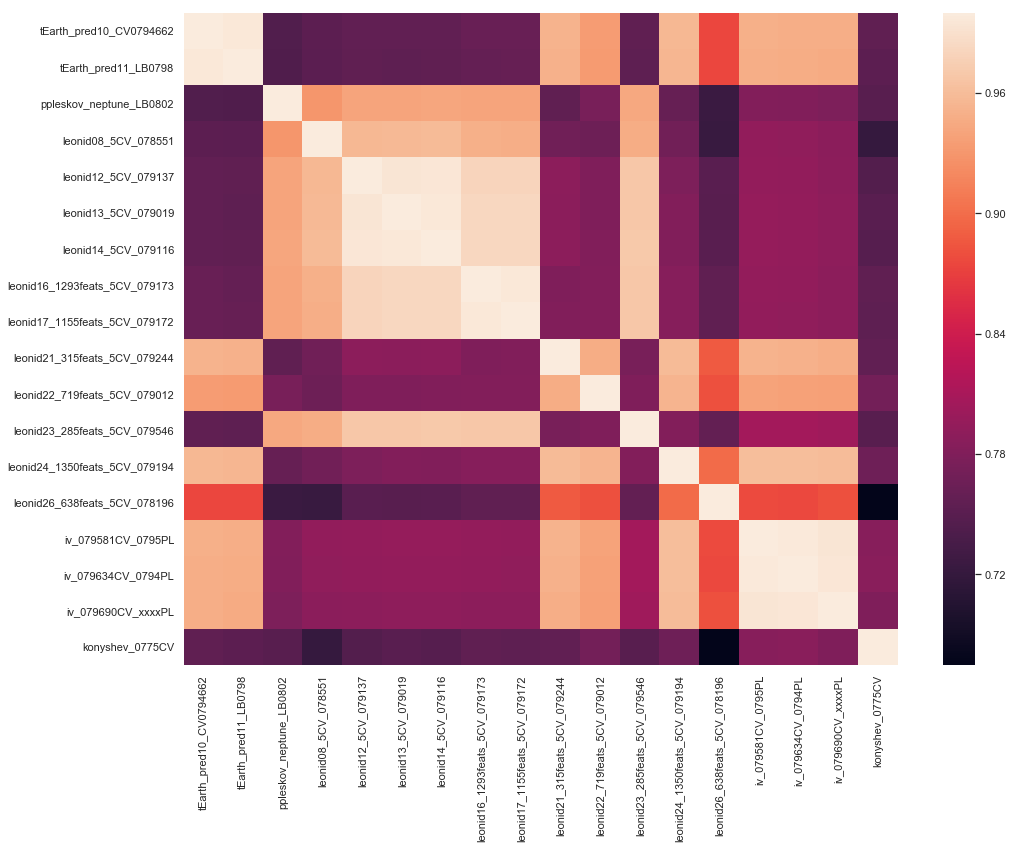

In [10]:

# calculate the correlation matrix
# corr = auto_df.corr()
corr = models_df[models_df['TARGET'].isnull()][[f for f in models_df.columns.tolist() if f not in ['SK_ID_CURR',
                                                                                                   'TARGET']]].corr()

# plot the heatmap
# plt.figure(figsize=(16,9))
sns.set(rc={'figure.figsize':(16,12)})
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [11]:
### Train predicts correlation

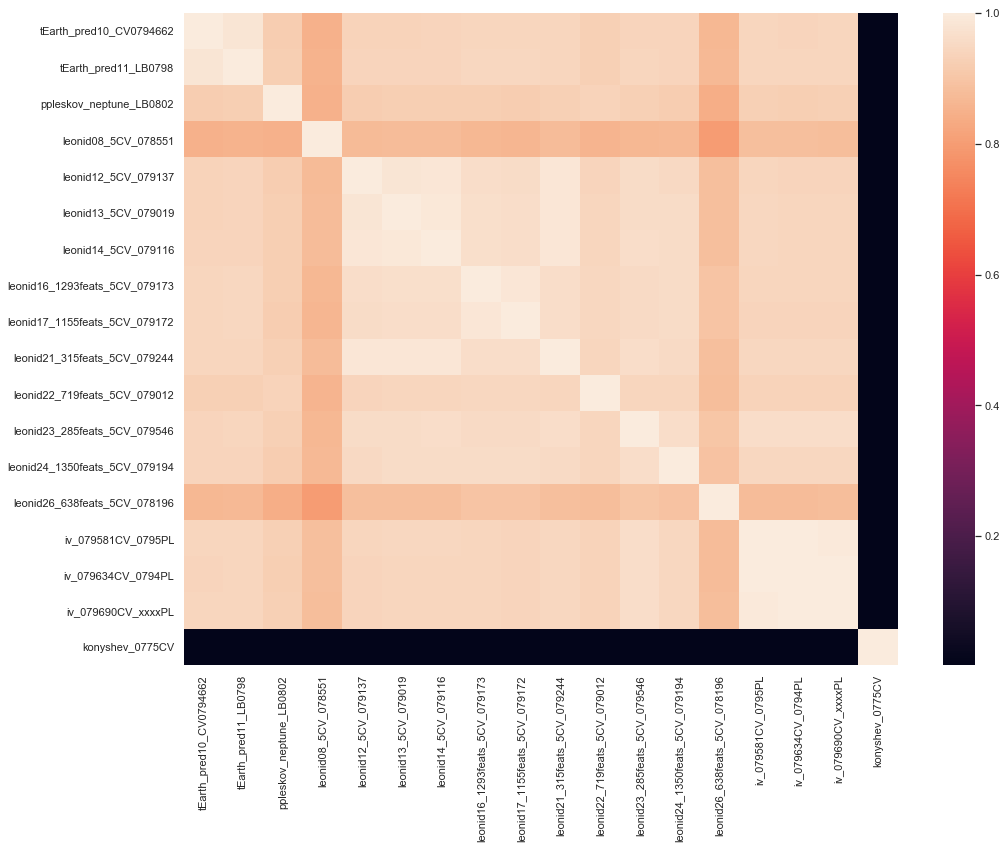

In [12]:
corr = models_df[models_df['TARGET'].notnull()][[f for f in models_df.columns.tolist() if f not in ['SK_ID_CURR',
                                                                                                   'TARGET']]].corr()

# plot the heatmap
# plt.figure(figsize=(16,9))
sns.set(rc={'figure.figsize':(16,12)})
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)